<a href="https://colab.research.google.com/github/dhkdsns20/AI-Basic/blob/main/showmap_dijkstra_final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Finding Algorithm
## Find strongest path with thpt

In [ ]:
!pip install osmnx




[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# from pyrosm import OSM
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import folium
import heapq

#  출발지 및 목적지 노드 설정 함수 정의
def get_nearest_node(G, latitude, longitude):
    """
    입력된 위도와 경도에 가장 가까운 그래프 노드를 찾는 함수.

    - G: 도로 네트워크 그래프
    - latitude: 위도
    - longitude: 경도

    반환: 가장 가까운 노드 ID
    """
    return ox.distance.nearest_nodes(G, longitude, latitude)

# 최단 경로 탐색 함수 정의
def find_shortest_path(G, origin_point, destination_point):
    """
    입력된 출발지와 목적지 간 최단 경로를 찾는 함수.

    - G: 도로 네트워크 그래프
    - origin_point: 출발지 좌표 (위도, 경도)
    - destination_point: 목적지 좌표 (위도, 경도)

    반환: 최단 경로 노드 리스트
    """
    # # 출발지와 목적지의 가장 가까운 노드 찾기
    # origin_node = get_nearest_node(G, *origin_point)
    # destination_node = get_nearest_node(G, *destination_point)

    # 최단 경로 계산 (Dijkstra 알고리즘)
    shortest_path = nx.shortest_path(G, origin_point, destination_point, weight='length',method="dijkstra") #
    return shortest_path


def plot_route(G, path):
    """
    최단 경로를 그래프에 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - path: 최단 경로 노드 리스트
    """
    if path is None or len(path) == 0:
        print("경로가 유효하지 않아 시각화를 생략합니다.")
        return

    try:
        fig, ax = ox.plot_graph_route(G, path, route_linewidth=2, node_size=0, bgcolor='k')
        plt.show()
    except Exception as e:
        print(f"경로 시각화 중 오류 발생: {e}")


# 도로만 남기는 함수
def create_filtered_graph(G, excluded_highway_types):
    """
    특정 highway 유형을 제외한 새로운 그래프를 반환하는 함수.

    - G: NetworkX 그래프
    - excluded_highway_types: 제외할 highway 유형 리스트 (예: ['footway'])

    반환: 제외된 엣지가 제거된 새로운 NetworkX 그래프
    """
    # 그래프 복사 (원본을 유지하기 위해)
    filtered_graph = G.copy()

    # 제거 대상 엣지 식별 및 제거
    edges_to_remove = [
        (u, v) for u, v, data in filtered_graph.edges(data=True)
        if data.get('highway') in excluded_highway_types
    ]
    filtered_graph.remove_edges_from(edges_to_remove)

    # print(f"Removed {len(edges_to_remove)} edges with highway types: {excluded_highway_types}")
    return filtered_graph

# 도로 네트워크 시각화 함수 정의 (Node ID 표시 추가) - 추가기능
def plot_map_with_node_ids(G, poi_coords=None):
    """
    도로 네트워크와 각 노드의 ID를 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - poi_coords: POI 위치 좌표 리스트 (선택적)
    """
    # 도로 네트워크 시각화
    fig, ax = ox.plot_graph(G, show=False, close=False)

    i = 1
    # 각 노드의 위치에 Node ID를 표시
    for node, data in G.nodes(data=True):
        x, y = data['x'], data['y']
        if node == 10666146667 or node == 9274780719:
            ax.text(x, y, str(node), fontsize=8, color='blue')  # Node ID 표시

    # POI 위치 시각화 (있을 경우)
    if poi_coords:
        y, x = zip(*poi_coords)
        ax.scatter(x, y, c='red', s=30, label='POI')
        ax.legend()

    plt.show()

# throughput 데이터를 노드에 매핑하는 함수 정의
def map_throughput_to_nodes(G, throughput_excel):
    """
    throughput 데이터를 그래프 노드 속성으로 매핑하는 함수.

    - G: 도로 네트워크 그래프
    - throughput_excel: 노드 ID와 throughput 값을 가진 DataFrame

    반환: throughput 속성이 추가된 그래프
    """
    # 노드 ID를 문자열로 변환하여 통일
    throughput_excel['Node ID'] = throughput_excel['Node ID'].astype(str)

    for node, data in G.nodes(data=True):
        # 그래프 노드 ID도 문자열로 변환
        node_str = str(node)
        # 노드 ID와 일치하는 Throughput 값을 찾음
        throughput_value = throughput_excel.loc[throughput_excel['Node ID'] == node_str, 'Throughput(Mbps)'].values
        if len(throughput_value) > 0:
            G.nodes[node]['throughput'] = throughput_value[0]  # Throughput 값을 노드에 추가
        else:
            G.nodes[node]['throughput'] = 0  # 데이터가 없을 경우 0으로 설정
    return G


# thpt을 가중치로 하여 신호 세기가 강한 경로를 찾는 알고리즘 함수 생성

In [ ]:
# 누적 가중치를 고려한 함수
def find_strongest_path(G, source, target):
    """
    Dijkstra 알고리즘을 수정하여 누적 가중치를 고려한 경로를 찾는 함수.

    - G: NetworkX 그래프
    - source: 출발 노드
    - target: 도착 노드

    반환:
    - 최단 경로의 노드 리스트
    - 경로의 누적 가중치
    """
    # 우선순위 큐 초기화 (누적 가중치 기준)
    queue = [(0, source, [])]  # (누적 가중치, 현재 노드, 경로)
    visited = set()

    while queue:
        cum_weight, current_node, path = heapq.heappop(queue)

        # 이미 방문한 노드는 무시
        if current_node in visited:
            continue
        visited.add(current_node)

        # 현재 노드를 경로에 추가
        path = path + [current_node]

        # 목표 노드에 도달하면 결과 반환
        if current_node == target:
            return path, cum_weight

        # 인접 노드 탐색
        for neighbor in G.neighbors(current_node):
            edge_data = G[current_node][neighbor]

            # ✅ 단일 간선 딕셔너리 접근 — Graph 타입에서는 이렇게 직접 접근해야 함
            edge_weight = edge_data.get('weight', float('inf'))

            # ✅ 유효한 가중치일 경우에만 큐에 추가
            if edge_weight < float('inf'):
                new_cum_weight = cum_weight + edge_weight
                heapq.heappush(queue, (new_cum_weight, neighbor, path))

            # # 최소 가중치 선택 (다중 간선 고려)
            # min_edge_weight = float('inf')
            # for key, data in edge_data.items():
            #     edge_weight = data.get('weight', float('inf'))
            #     if edge_weight is not None:
            #         min_edge_weight = min(min_edge_weight, edge_weight)

            # # 최소 가중치를 기반으로 경로 확장
            # if min_edge_weight < float('inf'):
            #     new_cum_weight = cum_weight + min_edge_weight
            #     heapq.heappush(queue, (new_cum_weight, neighbor, path))

    return None, float('inf')




# 가중치 계산 함수
def calculate_weight(throughput, distance, ratio):
    """
    - Throughput : Throughput 값
    - distance   : distance 값
    - ratio      : Throughput과 거리의 비율 (0~1)

    """
    # 최종 가중치 계산
    weight = (ratio * throughput) + ((1 - ratio) * distance)

    return weight




# 간선 가중치 설정 함수
def set_edge_weights_based_on_ratio(G, ratio):
    """
    간선의 가중치를 두 노드의 throughput 값과 거리 값의 비율로 설정하는 함수.
    - G: 도로 네트워크 그래프
    - ratio: Throughput:Distance 비율 (0~1)
    """

    for u, v, data in G.edges(data=True):
        # 노드의 throughput 값을 가져옴 (없으면 0으로 설정)
        throughput_u = G.nodes[u].get('throughput', 0)
        throughput_v = G.nodes[v].get('throughput', 0)
        distance = data.get('length', float('inf'))

        # 두 노드의 throughput 평균 계산
        avg_throughput = (throughput_u + throughput_v) / 2
        weight = calculate_weight(avg_throughput, distance, ratio)
        data['weight'] = weight
    return G


- 충북대 osm 불러오기 및 src, target 지정

출발지 노드 ID (청주 시외버스터미널): 8485871892
목적지 노드 ID (충북대학교 병원): 6200628380


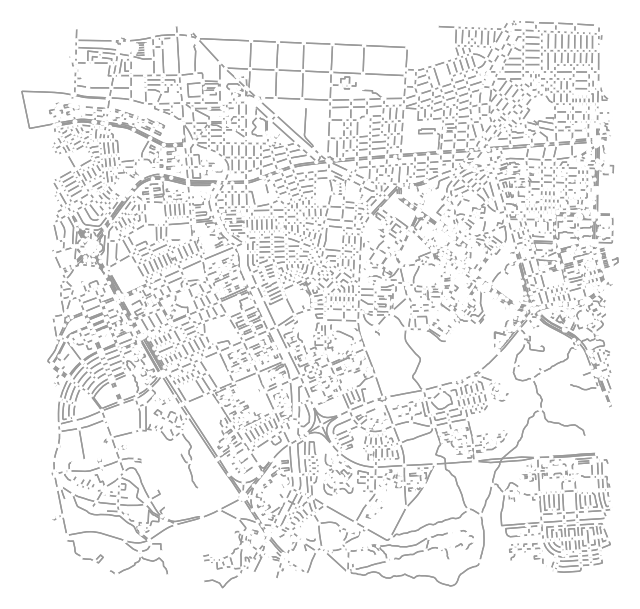

In [ ]:
# 출발지 및 목적지 좌표 설정
origin = (36.6256453, 127.4314837)        # 청주 시외버스터미널
destination = (36.6246818, 127.4638686)   # 충북대학교 병원

# 중심 좌표 계산 (중간 지점)
center_lat = (origin[0] + destination[0]) / 2
center_lon = (origin[1] + destination[1]) / 2
center_point = (center_lat, center_lon)

# 반경 2km 도로 네트워크 불러오기
radius = 2000  # 반경 2km
cheongju_graph = ox.graph_from_point(center_point, dist=radius, network_type="walk")

# 출발지와 목적지의 가장 가까운 노드 찾기
origin_node = get_nearest_node(cheongju_graph, *origin)
destination_node = get_nearest_node(cheongju_graph, *destination)

print(f"출발지 노드 ID (청주 시외버스터미널): {origin_node}")
print(f"목적지 노드 ID (충북대학교 병원): {destination_node}")

# 시각화로 반경 확인
fig, ax = ox.plot_graph(cheongju_graph, bgcolor='white', node_size=10, edge_linewidth=1)

In [ ]:
## 도보 제외한 네트워크 Graph 생성
# 제외할 highway 유형 설정
excluded_highways = ['footway']

# 필터링된 그래프 생성
filtered_graph = create_filtered_graph(cheongju_graph, excluded_highways)

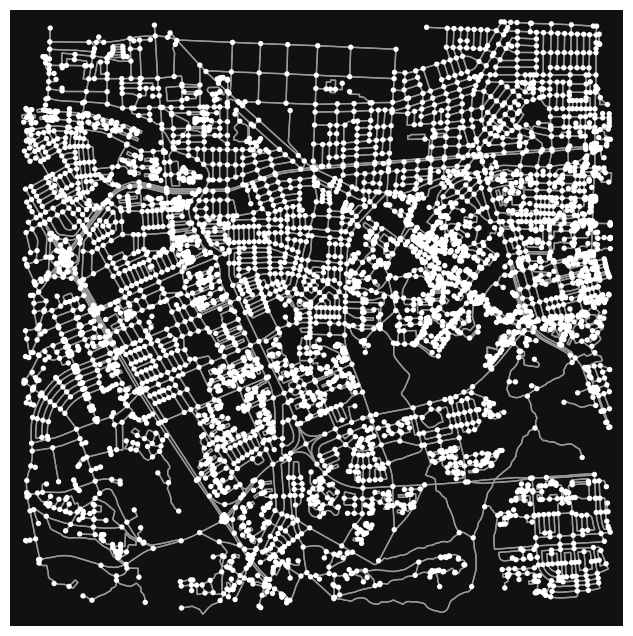

In [ ]:
plot_map_with_node_ids(filtered_graph)

- rxsite 노드 ID 반환 코드

## 유효 노드 (교차로 사이 노드 포함 : 도로생성을 위해서)

In [ ]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\601_PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\601_PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\601_PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45348 (\N{HANGUL SYLLABLE NE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\601_PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\601_PC\AppData\Local\Programs\Python\Python313\Lib\site-packag

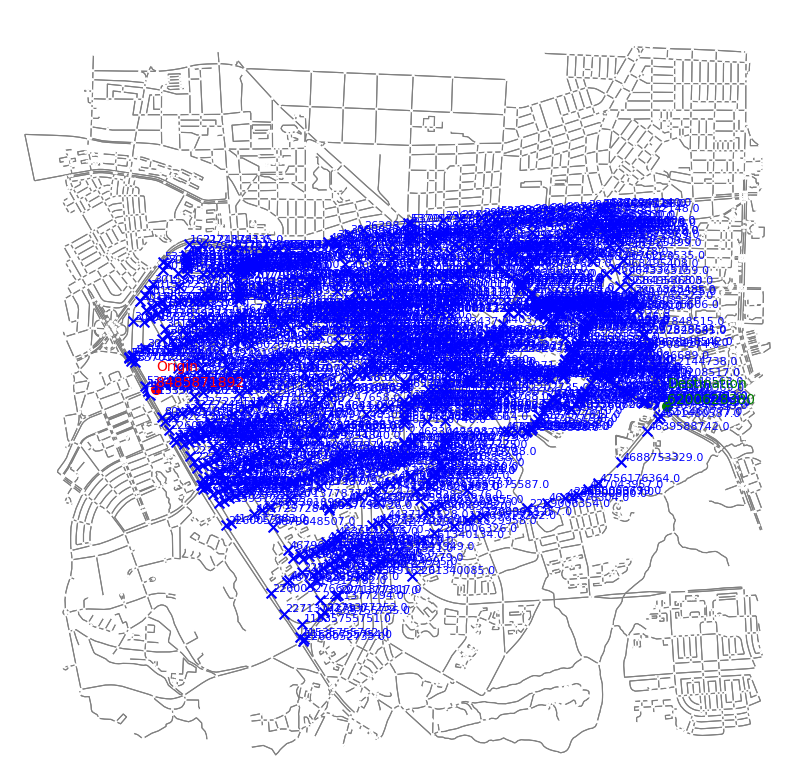

In [ ]:
# 단계 1 : 기본 유효 노드 집합 생성
# Rx 노드 ID 불러오기
rx_file_path = 'all_nodes_with_coordinates_throughput.xlsx'
rx_data = pd.read_excel(rx_file_path)
rx_node_ids = rx_data['Node ID'].tolist()

# 출발지 및 목적지 좌표 설정
origin = (36.6256453, 127.4314837)        # 청주 시외버스터미널
destination = (36.6246818, 127.4638686)   # 충북대학교 병원

# # OSM 데이터 로드
# cheongju_graph = ox.graph_from_place('Cheongju, South Korea', network_type='drive')

# 출발지와 목적지의 가장 가까운 노드 찾기
origin_node = ox.distance.nearest_nodes(cheongju_graph, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(cheongju_graph, destination[1], destination[0])

# # 출발지, 목적지, Rx 노드 ID 합치기
# valid_node_ids = set(rx_node_ids + [origin_node, destination_node])

# Rx 노드만 포함된 독립 그래프 생성
rx_graph = nx.Graph()
for _, row in rx_data.iterrows():
    node_id = row['Node ID']
    lat, lon = row['Latitude'], row['Longitude']
    rx_graph.add_node(node_id, x=lon, y=lat)

# 출발지, 목적지, Rx 노드만 포함하는 필터링된 그래프 생성
node_filtered_graph = cheongju_graph.subgraph(rx_node_ids).copy()

# 유효 노드들로 구성된 도로 찾기
valid_edges = []
for u, v, data in node_filtered_graph.edges(data=True):
    if u in rx_node_ids and v in rx_node_ids:  # Rx 노드 간 연결만 포함
        valid_edges.append((u, v))

# 유효 노드와 도로 시각화 개선
valid_graph = nx.Graph()
valid_graph.add_edges_from(valid_edges)
valid_graph.add_nodes_from(rx_node_ids)

# 빠른 시각화 함수
def plot_fast_graph(G, rx_graph, origin_node, destination_node):
    fig, ax = plt.subplots(figsize=(10,10))
    ox.plot_graph(G, ax=ax, node_size=5, node_color='white', edge_color='gray', edge_linewidth=0.8, show=False, close=False, bgcolor='black')

    # Rx 노드 시각화
    for node in rx_graph.nodes:
        x, y = rx_graph.nodes[node]['x'], rx_graph.nodes[node]['y']
        ax.scatter(x, y, c='blue', s=50, marker='x')
        ax.text(x + 0.0001, y + 0.0001, str(node), fontsize=8, color='blue')

    # 출발지 노드 표시
    x, y = G.nodes[origin_node]['x'], G.nodes[origin_node]['y']
    ax.scatter(x, y, c='red', s=100, label='Origin', marker='o', edgecolors='white', linewidths=2)
    ax.text(x, y, f'Origin\n{origin_node}', fontsize=10, color='red', ha='left', va='bottom')

    # 목적지 노드 표시
    x, y = G.nodes[destination_node]['x'], G.nodes[destination_node]['y']
    ax.scatter(x, y, c='green', s=100, label='Destination', marker='o', edgecolors='white', linewidths=2)
    ax.text(x, y, f'Destination\n{destination_node}', fontsize=10, color='green', ha='left', va='bottom')

    plt.title("도로 네트워크와 Rx 노드 시각화 (OSMnx + Matplotlib)", color='white', fontsize=14)
    plt.show()

# 시각화 실행
plot_fast_graph(cheongju_graph, rx_graph, origin_node, destination_node)


In [ ]:
# 출발지와 도착지를 별도로 관리
origin_destination_ids = {origin_node, destination_node}

# Rx 노드 (rx_graph 노드) 집합화
rx_only_node_ids = set(rx_graph.nodes)

# 전체 유효 노드
valid_node_ids = rx_only_node_ids | origin_destination_ids  # 합집합

# 출력
print(f"✅ Rx 노드 수: {len(rx_only_node_ids)}개")
print(f"✅ 출발지, 도착지 노드 수: {len(origin_destination_ids)}개")
print(f"✅ 전체 유효 노드 수 (Rx + 출발지/도착지): {len(valid_node_ids)}개")


✅ Rx 노드 수: 970개
✅ 출발지, 도착지 노드 수: 2개
✅ 전체 유효 노드 수 (Rx + 출발지/도착지): 970개


In [ ]:
def save_only_rx_nodes_with_coordinates(rx_graph, output_path):
    """
    Rx 노드만 Node ID + 위도(latitude) + 경도(longitude)를 엑셀로 저장하는 함수
    (출발지/도착지 노드는 저장하지 않음)
    """
    records = []

    # Rx 노드만 저장 (rx_graph 기준)
    for node in rx_graph.nodes:
        x = rx_graph.nodes[node].get('x', None)
        y = rx_graph.nodes[node].get('y', None)
        if x is not None and y is not None:
            records.append({'Node ID': node, 'latitude': y, 'longitude': x})

    # 데이터프레임으로 변환 및 엑셀 저장
    df = pd.DataFrame(records)
    df.to_excel(output_path, index=False)
    print(f"✅ 총 {len(records)}개 Rx 노드를 '{output_path}'에 저장했습니다.")

In [ ]:
# 저장 (출발지,목적지 총 2개의 노드는 제외)
save_only_rx_nodes_with_coordinates(
    rx_graph=rx_graph,
    output_path='only_rx_nodes_with_coordinates.xlsx'
)


✅ 총 970개 Rx 노드를 'only_rx_nodes_with_coordinates.xlsx'에 저장했습니다.


In [ ]:
import pandas as pd

# 1. 엑셀 파일 불러오기
file_path = 'all_nodes_with_coordinates_throughput.xlsx'
rx_data = pd.read_excel(file_path)

# 2. Throughput 컬럼을 bps → Mbps로 변환
rx_data['Throughput_Mbps'] = rx_data['Throughput'] / 1_000_000

# 3. 평균 계산 (Mbps 기준)
average_throughput_mbps = rx_data['Throughput_Mbps'].mean()

# 4. 출력
print(f"✅ 평균 처리율 (Mbps): {average_throughput_mbps:.4f} Mbps")


✅ 평균 처리율 (Mbps): 141.9643 Mbps


- Rx 노드 사이 도로 시각화

In [ ]:

# 출발지/도착지 제거된 Rx 노드만 포함
valid_node_ids = set(rx_only_node_ids)  # Rx 노드만

# 유효 노드들로 구성된 도로 찾기 (Rx 노드 간 최단 경로 포함)
valid_edges = []
for i in range(len(rx_node_ids)):
    for j in range(i + 1, len(rx_node_ids)):
        u, v = rx_node_ids[i], rx_node_ids[j]
        try:
            # Rx 노드 간 최단 경로 계산
            path = nx.shortest_path(cheongju_graph, source=u, target=v, weight='length')

            # 경로 상의 모든 노드를 추가
            for k in range(len(path) - 1):
                valid_edges.append((path[k], path[k+1]))
                valid_node_ids.add(path[k])
                valid_node_ids.add(path[k+1])
        except nx.NetworkXNoPath:
            # 경로가 없는 경우 무시
            continue

# 유효 그래프 재구성
valid_graph = nx.Graph()
valid_graph.add_edges_from(valid_edges)
valid_graph.add_nodes_from(valid_node_ids)


# # 시각화 함수 (Rx 노드 간 도로 포함)
# def plot_fast_graph(G, rx_graph, origin_node, destination_node):
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ox.plot_graph(G, ax=ax, node_size=5, node_color='white', edge_color='gray', edge_linewidth=0.8, show=False, close=False, bgcolor='black')

#     # Rx 노드 시각화
#     for node in rx_graph.nodes:
#         x, y = rx_graph.nodes[node]['x'], rx_graph.nodes[node]['y']
#         ax.scatter(x, y, c='blue', s=50, marker='x')
#         ax.text(x + 0.0001, y + 0.0001, str(node), fontsize=8, color='blue')

#     # 출발지 노드 표시
#     x, y = G.nodes[origin_node]['x'], G.nodes[origin_node]['y']
#     ax.scatter(x, y, c='red', s=100, label='Origin', marker='o', edgecolors='white', linewidths=2)
#     ax.text(x, y, f'Origin\n{origin_node}', fontsize=10, color='red', ha='left', va='bottom')

#     # 목적지 노드 표시
#     x, y = G.nodes[destination_node]['x'], G.nodes[destination_node]['y']
#     ax.scatter(x, y, c='green', s=100, label='Destination', marker='o', edgecolors='white', linewidths=2)
#     ax.text(x, y, f'Destination\n{destination_node}', fontsize=10, color='green', ha='left', va='bottom')

#     # Rx 노드 사이 도로 시각화
#     for u, v in valid_edges:
#         x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
#         x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
#         ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)

#     plt.title("도로 네트워크와 Rx 노드 연결 경로 시각화", color='white', fontsize=14)
#     plt.show()

# # 시각화 실행
# plot_fast_graph(cheongju_graph, rx_graph, origin_node, destination_node)


- 간선이 유효노드를 잇고 있는지 확인

In [ ]:
def verify_filtered_edges_connection(filtered_edges, valid_node_ids):
    """
    filtered_edges: 필터링된 trunk 간선 리스트
    valid_node_ids: 연결이 잘 되어야 하는 유효 노드 리스트/집합
    """
    # 1. 필터링된 간선으로 그래프 생성
    G_check = nx.Graph()
    G_check.add_edges_from(filtered_edges)

    # 2. 연결 컴포넌트 찾기
    components = list(nx.connected_components(G_check))

    # 3. 유효 노드들이 같은 컴포넌트에 있는지 확인
    for comp in components:
        if set(valid_node_ids).issubset(comp):
            print(f"✅ 모든 {len(valid_node_ids)}개의 유효 노드가 하나의 연결 컴포넌트 안에 있습니다.")
            return True

    print(f"❌ 유효 노드들이 하나의 연결 컴포넌트에 있지 않습니다.")
    return False

In [ ]:
# 예시
verify_filtered_edges_connection(valid_edges, rx_node_ids)


✅ 모든 970개의 유효 노드가 하나의 연결 컴포넌트 안에 있습니다.


True

### Throughput 매칭
- thpt dataset 불러오기

In [ ]:
# 엑셀 comm data(throughput) 불러오기
throughput_excel = pd.read_excel('all_nodes_with_coordinates_throughput.xlsx')

# throughput 정보를 노드에 매핑
G_set_node = map_throughput_to_nodes(valid_graph, throughput_excel)

- mapping 확인

In [ ]:
def print_throughput_of_valid_nodes(G, rx_node_ids):
    """
    G: throughput이 매핑된 그래프 (G_set_node)
    rx_node_ids: Rx 유효 노드 리스트 또는 집합
    유효 노드들의 처리율(throughput) 값을 출력하는 함수
    """
    count_found = 0
    count_missing = 0

    for node in rx_node_ids:
        if node in G.nodes:
            throughput = G.nodes[node].get('throughput', None)
            if throughput is not None:
                print(f"Node {node}: throughput = {throughput}")
                count_found += 1
            else:
                print(f"❌ Node {node}: throughput 정보 없음")
                count_missing += 1
        else:
            print(f"❌ Node {node}: 그래프에 존재하지 않음")
            count_missing += 1

    print(f"\n✅ 처리율 정보 있는 노드 수: {count_found}개")
    print(f"❌ 처리율 정보 없는 노드 수: {count_missing}개")


In [ ]:
print_throughput_of_valid_nodes(G_set_node, rx_node_ids)

Node 3015872343: throughput = 94.8019175459969
Node 4656035229: throughput = 95.53740928833508
Node 3000023775: throughput = 99.0292159901008
Node 4636543383: throughput = 99.05519831471653
Node 4679744568: throughput = 101.6534742301377
Node 3000023509: throughput = 102.41578470307306
Node 4636543376: throughput = 103.00079413626591
Node 4656937191: throughput = 103.14329664222741
Node 4657017758: throughput = 103.17435721096385
Node 3000023440: throughput = 103.34613959495162
Node 3015872375: throughput = 103.92013283245082
Node 3015872364: throughput = 105.03445360054079
Node 3000023812: throughput = 105.21386883968682
Node 2968495409: throughput = 105.42707928019547
Node 4679744909: throughput = 106.67281533552021
Node 2272245054: throughput = 107.03871494229352
Node 3000023442: throughput = 107.36626968222517
Node 3000023511: throughput = 109.21881981522924
Node 4683067432: throughput = 109.8904544727807
Node 4636543387: throughput = 110.20821778822905
Node 4679754838: throughput 

In [ ]:
# # 출발 노드와 도착 노드 지정
# # (origin_node, destination_node는 파일 안에 이미 있음)

# # 처리율 기반 최적 경로 찾기
# throughput_based_path = nx.shortest_path(G_set_node, source=origin_node, target=destination_node, weight='new_weight', method="dijkstra")

# print("🚀 처리율 기반 경로:", throughput_based_path)
# 2. 비율별 경로 탐색 함수
def find_path_for_ratios(G, ratios, source, target):
    """
    G: 그래프
    ratios: 거리:처리율 비율 리스트
    source: 출발 노드
    target: 도착 노드
    """
    paths = {}
    for ratio in ratios:
        # 그래프 복사해서 매번 fresh하게 가중치 설정
        G_temp = G.copy()
        G_temp = set_edge_weights_based_on_ratio(G_temp, ratio)

        try:
            path = nx.shortest_path(G_temp, source=source, target=target, weight='weight', method='dijkstra')
            paths[ratio] = path
            print(f"\n🚀 거리:처리율 비율 {ratio:.1f}:{1-ratio:.1f} 경로:")
            print(path)
        except nx.NetworkXNoPath:
            print(f"\n❌ 거리:처리율 비율 {ratio:.1f}:{1-ratio:.1f} - 경로를 찾을 수 없습니다.")

    return paths

# 3. 실행
ratios = [0, 0.3, 0.6, 1.0]  # 거리:처리율 비율
paths_result = find_path_for_ratios(G_set_node, ratios, origin_node, destination_node)



🚀 거리:처리율 비율 0.0:1.0 경로:
[8485871892, 11535631438, 11535631437, 4657179295, 5370128281, 3015872402, 2272245177, 3791819479, 1621248629, 2271378269, 4679763988, 4657247656, 2260052923, 2918310206, 1806881875, 2260052845, 3957495727, 4670424839, 4670424837, 4670424838, 2269006369, 4682813858, 3957495728, 4657375587, 437043951, 12609615257, 2269006354, 4641476304, 4866000800, 2269006367, 4866000799, 437043957, 4756176364, 4688753329, 4639588742, 4641480587, 4656460777, 2967848549, 3958352335, 6200628380]

🚀 거리:처리율 비율 0.3:0.7 경로:
[8485871892, 11535631438, 11535631437, 4657179295, 5370128281, 3015872402, 2272245177, 3791819479, 1621248629, 2271378269, 4679763988, 4657247656, 2260052923, 2918310206, 1806881875, 2260052845, 3957495727, 4670424839, 4670424837, 4670424838, 2269006369, 4682813858, 3957495728, 4657375587, 437043951, 12609615257, 2269006354, 4641476304, 4866000800, 2269006367, 4866000799, 437043957, 4756176364, 4688753329, 4639588742, 4641480587, 4656460777, 2967848549, 3958352335

In [ ]:
# 1. Rx 노드 좌표 불러오기
rx_coord_df = pd.read_excel('only_rx_nodes_with_coordinates.xlsx')
rx_coord_dict = {
    int(row['Node ID']): (row['longitude'], row['latitude'])
    for _, row in rx_coord_df.iterrows()
}

# 2. 노드 좌표 찾는 함수
def get_node_coordinates(node_id, rx_coord_dict, backup_graph):
    """
    - node_id: 찾을 노드 ID
    - rx_coord_dict: Rx 노드 좌표 딕셔너리
    - backup_graph: 좌표가 없을 때 참고할 그래프 (cheongju_graph)

    반환: (x, y) 튜플
    """
    if node_id in rx_coord_dict:
        return rx_coord_dict[node_id]
    elif node_id in backup_graph.nodes:
        node_data = backup_graph.nodes[node_id]
        return (node_data.get('x', None), node_data.get('y', None))
    else:
        print(f"❌ 노드 {node_id}에 대한 좌표를 찾을 수 없습니다.")
        return (None, None)

# folium으로 경로를 지도에 그리는 함수
def plot_path_on_real_map(path, rx_coord_dict, backup_graph, origin_node, destination_node, title="Throughput 기반 경로 실지도 시각화"):
    """
    - path: 경로에 포함된 노드 리스트
    - rx_coord_dict: Rx 노드 좌표
    - backup_graph: 중간 노드 좌표 (cheongju_graph)
    - origin_node: 출발 노드 ID
    - destination_node: 도착 노드 ID
    - title: 지도 제목
    """
    # 출발지 좌표로 지도 중심
    start_lon, start_lat = get_node_coordinates(origin_node, rx_coord_dict, backup_graph)
    m = folium.Map(location=[start_lat, start_lon], zoom_start=15)

    # 경로 만들기
    path_coordinates = []
    for node_id in path:
        lon, lat = get_node_coordinates(node_id, rx_coord_dict, backup_graph)
        if None not in (lon, lat):
            path_coordinates.append((lat, lon))  # folium은 (위도, 경도)

    # 경로 폴리라인 추가
    folium.PolyLine(
        locations=path_coordinates,
        color='red',
        weight=5,
        opacity=0.8,
        popup=title
    ).add_to(m)

    # 출발지 마커
    start_coords = get_node_coordinates(origin_node, rx_coord_dict, backup_graph)
    folium.Marker(
        location=(start_coords[1], start_coords[0]),
        popup="Origin",
        icon=folium.Icon(color='red', icon='play')
    ).add_to(m)

    # 도착지 마커
    end_coords = get_node_coordinates(destination_node, rx_coord_dict, backup_graph)
    folium.Marker(
        location=(end_coords[1], end_coords[0]),
        popup="Destination",
        icon=folium.Icon(color='green', icon='flag')
    ).add_to(m)

    return m



In [ ]:
# 비율 리스트
ratios = [0.0, 0.2, 0.8, 1.0]

# 비율별 folium 지도 생성
maps = {}

for ratio in ratios:
    path = paths_result.get(ratio)
    if path is not None:
        title = f"Throughput 기반 최적 경로 실지도 시각화 (비율 {ratio:.1f}:{1-ratio:.1f})"
        folium_map = plot_path_on_real_map(
            path=path,
            rx_coord_dict=rx_coord_dict,
            backup_graph=cheongju_graph,
            origin_node=origin_node,
            destination_node=destination_node,
            title=title
        )
        maps[ratio] = folium_map


In [ ]:
maps[0.0]

In [ ]:
maps[0.3]

In [ ]:
maps[0.6]

In [ ]:
maps[1.0]

In [ ]:
!pip install haversine


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from haversine import haversine
from datetime import time

def calculate_distance(u, v, rx_coord_dict, backup_graph):
    lon1, lat1 = get_node_coordinates(u, rx_coord_dict, backup_graph)
    lon2, lat2 = get_node_coordinates(v, rx_coord_dict, backup_graph)

    if None not in (lon1, lat1, lon2, lat2):
        distance_km = haversine((lat1, lon1), (lat2, lon2))
        return distance_km * 1000  # meter 변환
    else:
        return float('inf')

def determine_base_speed(current_time):
    """
    시간대에 따라 기본 속도 반환
    (※ 정체계수 무시, 신호대기 무시)
    """
    hour = current_time.hour

    if 7 <= hour < 9:  # 출근시간
        return 20  # km/h
    elif 10 <= hour < 16:  # 낮 시간
        return 25
    elif 17 <= hour < 19:  # 퇴근시간
        return 20
    else:  # 야간 등
        return 30

def estimate_travel_time_simple(total_distance_meters, current_time):
    """
    거리와 시간대에 따라 단순 소요시간 계산
    (※ 기본 속도만 적용, 정체계수 및 신호대기 무시)
    """
    base_speed = determine_base_speed(current_time)
    speed_mps = base_speed * 1000 / 3600  # km/h → m/s 변환

    move_time_seconds = total_distance_meters / speed_mps
    move_time_minutes = move_time_seconds / 60

    return move_time_seconds, move_time_minutes, base_speed

def summarize_single_path_for_time(G, path, ratio_label, current_time, time_label):
    num_nodes = len(path)
    total_distance = 0
    throughput_list = []

    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]

        if G.has_edge(u, v):
            edge_data = G[u][v]
            distance = edge_data.get('length', None)

            if distance is None:
                distance = calculate_distance(u, v, rx_coord_dict, cheongju_graph)

            throughput_u = G.nodes[u].get('throughput', 0)
            throughput_v = G.nodes[v].get('throughput', 0)
            avg_throughput = (throughput_u + throughput_v) / 2

            total_distance += distance
            throughput_list.append(avg_throughput)

    if throughput_list:
        avg_throughput = sum(throughput_list) / len(throughput_list)
        min_throughput = min(throughput_list)
        max_throughput = max(throughput_list)
    else:
        avg_throughput = min_throughput = max_throughput = 0

    # 소요시간 계산 (기본 속도만)
    time_sec, time_min, base_speed = estimate_travel_time_simple(
        total_distance,
        current_time=current_time
    )

    # 출력
    print(f"\n🕑 [{time_label}] 비율 {ratio_label} 경로:")
    print(path)
    print(f" - 노드 수: {num_nodes}")
    print(f" - 총 거리: {total_distance:.2f} m")
    print(f" - 기본 속도: {base_speed} km/h")
    print(f" - 소요 시간: {time_sec:.1f}초 ≈ {time_min:.1f}분")
    print(f" - 평균 처리율: {avg_throughput:.2f}")
    print(f" - 최소 처리율: {min_throughput:.2f}")
    print(f" - 최대 처리율: {max_throughput:.2f}")

# 3개 시간대 설정
time_periods = {
    "오전(08:00)": time(8, 0),
    "오후(14:00)": time(14, 0),
    "저녁(18:00)": time(18, 0)
}



# 4개 비율 모두 순차 출력
for time_label, time_value in time_periods.items():
    for ratio in [0.0, 0.3, 0.6, 1.0]:
        path = paths_result.get(ratio)
        if path:
            summarize_single_path_for_time(G_set_node, path, f"{ratio:.1f}:{1-ratio:.1f}", time_value, time_label)



🕑 [오전(08:00)] 비율 0.0:1.0 경로:
[8485871892, 11535631438, 11535631437, 4657179295, 5370128281, 3015872402, 2272245177, 3791819479, 1621248629, 2271378269, 4679763988, 4657247656, 2260052923, 2918310206, 1806881875, 2260052845, 3957495727, 4670424839, 4670424837, 4670424838, 2269006369, 4682813858, 3957495728, 4657375587, 437043951, 12609615257, 2269006354, 4641476304, 4866000800, 2269006367, 4866000799, 437043957, 4756176364, 4688753329, 4639588742, 4641480587, 4656460777, 2967848549, 3958352335, 6200628380]
 - 노드 수: 40
 - 총 거리: 4238.34 m
 - 기본 속도: 20 km/h
 - 소요 시간: 762.9초 ≈ 12.7분
 - 평균 처리율: 143.21
 - 최소 처리율: 143.01
 - 최대 처리율: 143.84

🕑 [오전(08:00)] 비율 0.3:0.7 경로:
[8485871892, 11535631438, 11535631437, 4657179295, 5370128281, 3015872402, 2272245177, 3791819479, 1621248629, 2271378269, 4679763988, 4657247656, 2260052923, 2918310206, 1806881875, 2260052845, 3957495727, 4670424839, 4670424837, 4670424838, 2269006369, 4682813858, 3957495728, 4657375587, 437043951, 12609615257, 2269006354, 464

In [ ]:
!pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd

summary_list = []

for time_label, time_value in time_periods.items():
    for ratio in [0.0, 0.3, 0.6, 1.0]:
        path = paths_result.get(ratio)
        if path:
            num_nodes = len(path)
            total_distance = 0
            throughput_list = []

            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]

                if G_set_node.has_edge(u, v):
                    edge_data = G_set_node[u][v]
                    distance = edge_data.get('length', None)

                    if distance is None:
                        distance = calculate_distance(u, v, rx_coord_dict, cheongju_graph)

                    throughput_u = G_set_node.nodes[u].get('throughput', 0)
                    throughput_v = G_set_node.nodes[v].get('throughput', 0)
                    avg_throughput = (throughput_u + throughput_v) / 2

                    total_distance += distance
                    throughput_list.append(avg_throughput)

            if throughput_list:
                avg_throughput = sum(throughput_list) / len(throughput_list)
                min_throughput = min(throughput_list)
                max_throughput = max(throughput_list)
            else:
                avg_throughput = min_throughput = max_throughput = 0

            time_sec, time_min, base_speed = estimate_travel_time_simple(
                total_distance,
                current_time=time_value
            )

            summary_list.append({
                "시간대": time_label,
                "비율": f"{ratio:.1f}:{1-ratio:.1f}",
                "노드 수": num_nodes,
                "거리(m)": round(total_distance, 2),
                "기본 속도(km/h)": base_speed,
                "소요 시간(초)": round(time_sec, 1),
                "소요 시간(분)": round(time_min, 1),
                "평균 처리율": round(avg_throughput, 2),
                "최소 처리율": round(min_throughput, 2),
                "최대 처리율": round(max_throughput, 2)
            })

# # 스타일 적용 전 설정
# pd.set_option('display.unicode.east_asian_width', True)

# # 시간대별로 구획을 나눠서 정렬 출력
# for time_label, group_df in df_summary.groupby("시간대"):
#     print(f"\n📌 {time_label} 시간대 경로 요약")
#     print(group_df.to_string(index=False))

from tabulate import tabulate

for time_label, group_df in df_summary.groupby("시간대"):
    print(f"\n📌 {time_label} 시간대 경로 요약")
    print(tabulate(group_df, headers='keys', tablefmt='grid', showindex=False))


# DataFrame으로 출력
df_summary = pd.DataFrame(summary_list)
print(df_summary)



📌 오전(08:00) 시간대 경로 요약
+-------------+---------+-----------+-----------+-------------------+-----------------+-----------------+---------------+---------------+---------------+
| 시간대      | 비율    |   노드 수 |   거리(m) |   기본 속도(km/h) |   소요 시간(초) |   소요 시간(분) |   평균 처리율 |   최소 처리율 |   최대 처리율 |
+=============+=========+===========+===========+===================+=================+=================+===============+===============+===============+
| 오전(08:00) | 0.0:1.0 |        40 |   4238.34 |                20 |           762.9 |            12.7 |        143.21 |        143.01 |        143.84 |
+-------------+---------+-----------+-----------+-------------------+-----------------+-----------------+---------------+---------------+---------------+
| 오전(08:00) | 0.3:0.7 |        40 |   4238.34 |                20 |           762.9 |            12.7 |        143.21 |        143.01 |        143.84 |
+-------------+---------+-----------+-----------+-------------------+-----------------+---------

In [ ]:
from tabulate import tabulate

with open("경로_요약_결과_전체출력.txt", "w", encoding="utf-8") as f:
    for time_label, group_df in df_summary.groupby("시간대"):
        f.write(f"\n📌 {time_label} 시간대 경로 요약\n")
        f.write(tabulate(group_df, headers="keys", tablefmt="grid", showindex=False))
        f.write("\n\n")


In [ ]:
edge_summary = []

for u, v in G_set_node.edges():
    # 기본 거리 가져오기
    edge_data = G_set_node[u][v]
    distance = edge_data.get('length')

    # 거리 정보가 없는 경우 haversine 수동 계산
    if distance is None:
        # 1. 우선 노드에 직접 x, y 좌표가 있는지 확인
        lon1 = G_set_node.nodes[u].get('x')
        lat1 = G_set_node.nodes[u].get('y')
        lon2 = G_set_node.nodes[v].get('x')
        lat2 = G_set_node.nodes[v].get('y')

        # 2. 없다면 백업 좌표 딕셔너리에서 찾기
        if None in (lon1, lat1) and rx_coord_dict.get(u):
            lon1, lat1 = rx_coord_dict[u]
        if None in (lon2, lat2) and rx_coord_dict.get(v):
            lon2, lat2 = rx_coord_dict[v]

        # 3. 좌표가 모두 있다면 거리 계산
        if None not in (lon1, lat1, lon2, lat2):
            distance = haversine((lat1, lon1), (lat2, lon2)) * 1000  # m 단위
        else:
            distance = None  # 좌표 부족하면 포기

    # 처리율 정보
    throughput_u = G_set_node.nodes[u].get('throughput', 0)
    throughput_v = G_set_node.nodes[v].get('throughput', 0)
    avg_throughput = (throughput_u + throughput_v) / 2

    edge_summary.append({
        "출발 노드": u,
        "도착 노드": v,
        "거리 (m)": round(distance, 2) if distance else None,
        "출발 노드 Throughput": throughput_u,
        "도착 노드 Throughput": throughput_v,
        "평균 Throughput": round(avg_throughput, 2)
    })

# 저장
df_edges = pd.DataFrame(edge_summary)
df_edges.to_excel("노드간_거리_및_처리율_보완.xlsx", index=False)


## 데이터 전처리

In [ ]:
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import seaborn as sns

def plot_distribution(df, distance_col="distance (m)", throughput_col="average Throughput"):
    plt.figure(figsize=(14, 5))

    # 거리 분포
    plt.subplot(1, 2, 1)
    sns.histplot(df[distance_col], kde=True, color="skyblue")
    plt.title("Distance", fontsize=14)
    plt.xlabel('distance(m)', fontsize=12)
    plt.ylabel("num", fontsize=12)

    # 처리율 분포
    plt.subplot(1, 2, 2)
    sns.histplot(df[throughput_col], kde=True, color="salmon")
    plt.title("Throughput", fontsize=14)
    plt.xlabel('average Throughput', fontsize=12)
    plt.ylabel("num", fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_data(df, distance_col="distance (m)", throughput_col="average Throughput"):
    scaler = StandardScaler()
    norm_values = scaler.fit_transform(df[[distance_col, throughput_col]])
    df_norm = df.copy()
    df_norm["distance_norm"] = norm_values[:, 0]
    df_norm["throughput_norm"] = norm_values[:, 1]
    return df_norm


In [ ]:
def clip_and_rescale(df, norm_distance_col="distance_norm", norm_throughput_col="throughput_norm", quantile=0.1):
    df_clipped = df.copy()

    # 1️⃣ 거리 클리핑
    d_lower = df_clipped[norm_distance_col].quantile(quantile)
    d_upper = df_clipped[norm_distance_col].quantile(1 - quantile)
    df_clipped[norm_distance_col] = df_clipped[norm_distance_col].clip(lower=d_lower, upper=d_upper)

    # 2️⃣ 처리율 클리핑
    t_lower = df_clipped[norm_throughput_col].quantile(quantile)
    t_upper = df_clipped[norm_throughput_col].quantile(1 - quantile)
    df_clipped[norm_throughput_col] = df_clipped[norm_throughput_col].clip(lower=t_lower, upper=t_upper)

    # 3️⃣ 분산(표준편차) 맞추기: 처리율 스케일을 조정 (평균 고정)
    std_distance = df_clipped[norm_distance_col].std()
    std_throughput = df_clipped[norm_throughput_col].std()
    mean_throughput = df_clipped[norm_throughput_col].mean()

    if std_throughput != 0:
        scale_factor = std_distance / std_throughput #현재 처리율의 표준편차를 거리의 표준편차에 맞추기 위해 필요한 비율
        df_clipped[norm_throughput_col] = (
            (df_clipped[norm_throughput_col] - mean_throughput) * scale_factor + mean_throughput
        )
        print(f"✅ 처리율 스케일 조정: 표준편차 {std_throughput:.3f} -> {std_distance:.3f}, 평균 유지({mean_throughput:.3f})")
    else:
        print("⚠️ 처리율의 표준편차가 0이라 스케일 조정이 불가능합니다.")

    return df_clipped


In [ ]:
def plot_normalized_distribution(df, norm_distance_col="distance_norm", norm_throughput_col="throughput_norm", title_suffix=""):
    plt.figure(figsize=(14, 5))

    # 거리 분포
    plt.subplot(1, 2, 1)
    sns.histplot(df[norm_distance_col], kde=True, color="dodgerblue")
    plt.title(f"Normalized Distance Distribution {title_suffix}", fontsize=14)
    plt.xlabel(norm_distance_col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    # 처리율 분포
    plt.subplot(1, 2, 2)
    sns.histplot(df[norm_throughput_col], kde=True, color="orangered")
    plt.title(f"Normalized Throughput Distribution {title_suffix}", fontsize=14)
    plt.xlabel(norm_throughput_col, fontsize=12)
    plt.ylabel("Count", fontsize=12)

    plt.tight_layout()
    plt.show()


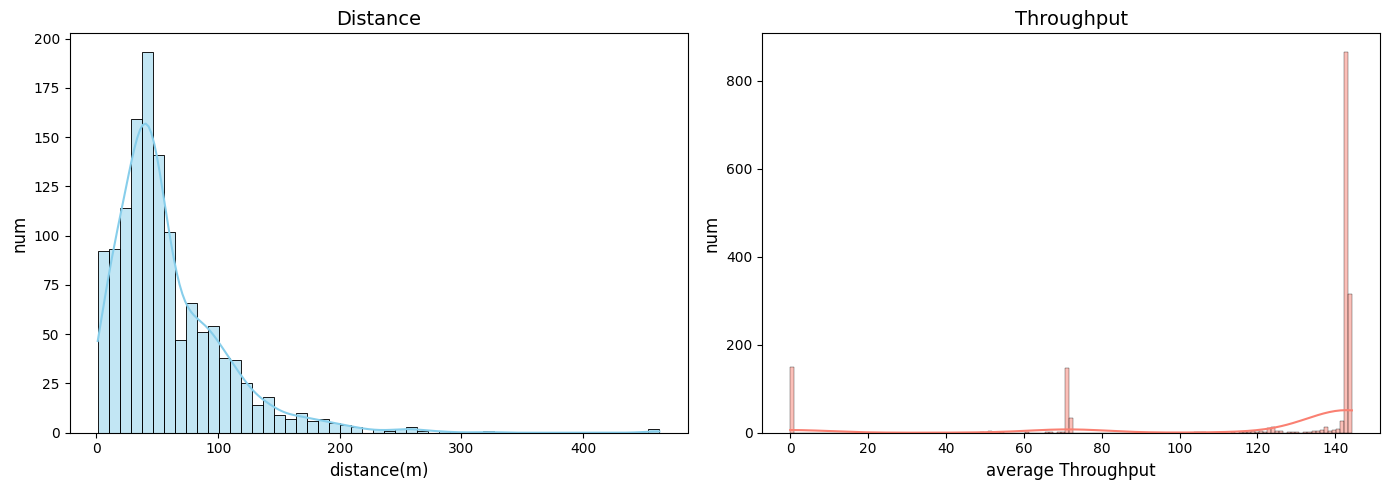

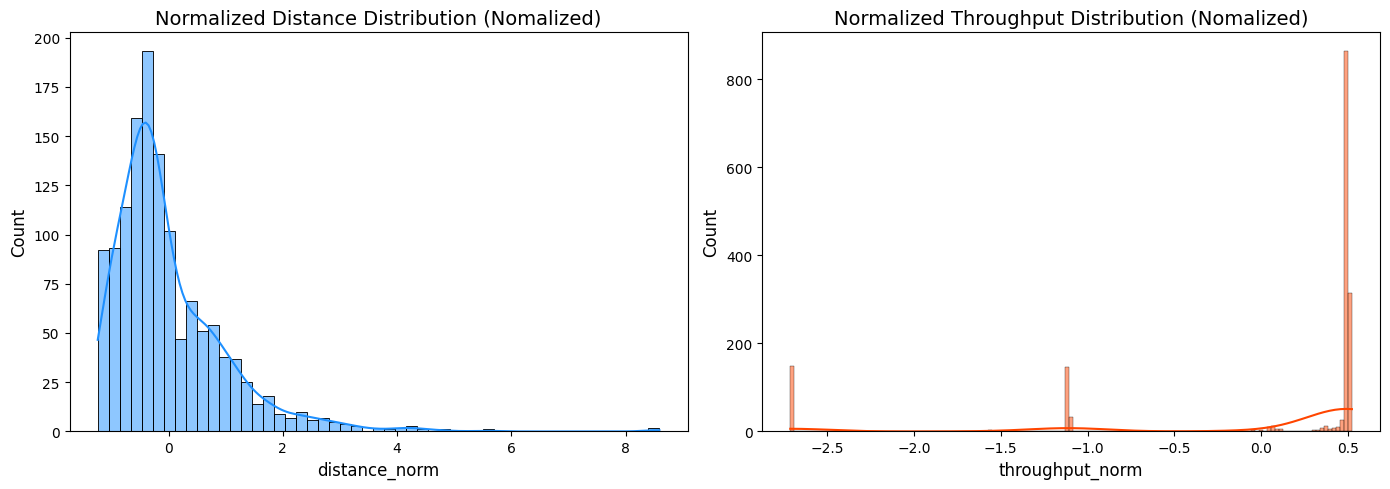

✅ 처리율 스케일 조정: 표준편차 0.059 -> 0.425, 평균 유지(0.461)


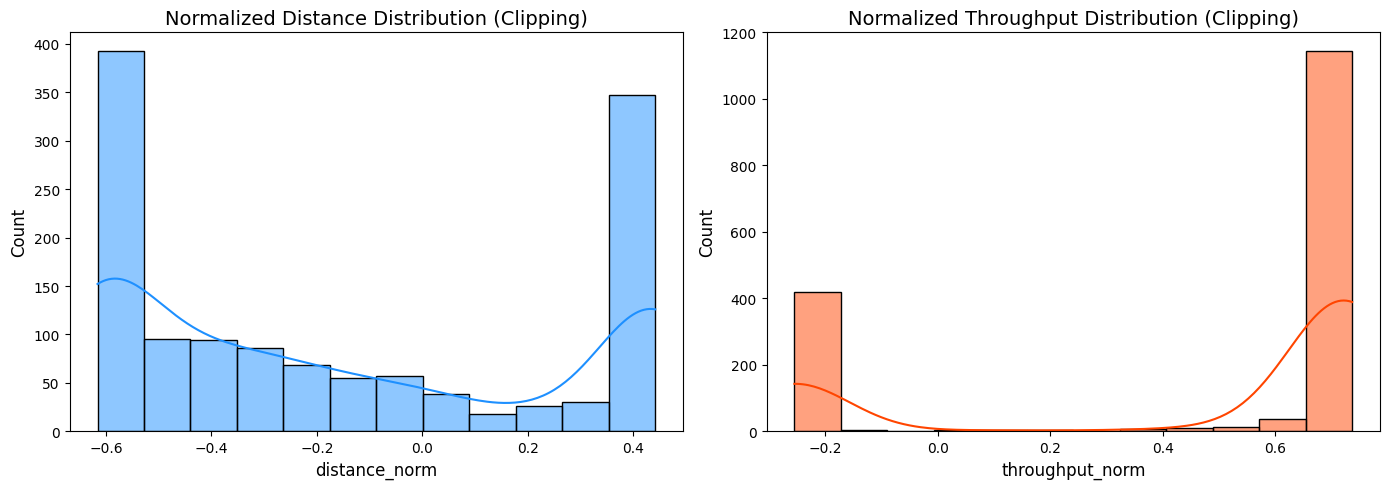

In [ ]:
# 1️⃣ 엑셀 데이터 로드
df = pd.read_excel(r"g:\내 드라이브\[4학년]\[졸업 작품]\distance_Throughput.xlsx")


# 2️⃣ 원본 분포 시각화
plot_distribution(df)

# 3️⃣ 표준편차 동일 정규화
df_norm = normalize_data(df)

# 4️⃣ 정규화 후 분포 시각화
plot_normalized_distribution(df_norm, title_suffix="(Nomalized)")

# 5️⃣ 극단값 클리핑
df_rescaled = clip_and_rescale(df_norm, quantile=0.25)


# 6️⃣ 클리핑 후 분포 시각화
plot_normalized_distribution(df_rescaled, title_suffix="(Clipping)")


In [ ]:
def summarize_after_clipping(df, norm_distance_col="distance_norm", norm_throughput_col="throughput_norm"):
    print("\n📊 [거리 요약]")
    print(f"- 최소값: {df[norm_distance_col].min():.3f}")
    print(f"- 최대값: {df[norm_distance_col].max():.3f}")
    print(f"- 평균: {df[norm_distance_col].mean():.3f}")
    print(f"- 표준편차: {df[norm_distance_col].std():.3f}")
    print(f"- 10% quantile: {df[norm_distance_col].quantile(0.1):.3f}")
    print(f"- 90% quantile: {df[norm_distance_col].quantile(0.9):.3f}")
    print(f"- 개수: {len(df)}")

    print("\n📊 [처리율 요약]")
    print(f"- 최소값: {df[norm_throughput_col].min():.3f}")
    print(f"- 최대값: {df[norm_throughput_col].max():.3f}")
    print(f"- 평균: {df[norm_throughput_col].mean():.3f}")
    print(f"- 표준편차: {df[norm_throughput_col].std():.3f}")
    print(f"- 10% quantile: {df[norm_throughput_col].quantile(0.1):.3f}")
    print(f"- 90% quantile: {df[norm_throughput_col].quantile(0.9):.3f}")
    print(f"- 개수: {len(df)}")


In [ ]:
# df_rescaled는 clip_and_rescale 이후 반환된 데이터프레임
summarize_after_clipping(df_rescaled)



📊 [거리 요약]
- 최소값: -0.616
- 최대값: 0.442
- 평균: -0.154
- 표준편차: 0.425
- 10% quantile: -0.616
- 90% quantile: 0.442
- 개수: 1648

📊 [처리율 요약]
- 최소값: -0.255
- 최대값: 0.737
- 평균: 0.461
- 표준편차: 0.425
- 10% quantile: -0.255
- 90% quantile: 0.737
- 개수: 1648
